# 	Write a script using R or Python to access the [FRN Status dataset](https://opendata.usac.org/E-rate/E-rate-Request-for-Discount-on-Services-FRN-Status/qdmp-ygft) available on the [USAC Open Data Platform](https://opendata.usac.org/) using the [Socrata Open Data API](https://dev.socrata.com/foundry/opendata.usac.org/qtkm-he8k)’s SOQL language: 
Here are some additional links to get you started on querying the Socrata Open Data API (SODA):  
     https://dev.socrata.com/docs/endpoints.html  
     https://dev.socrata.com/docs/filtering.html  
     https://dev.socrata.com/docs/queries/  
     https://dev.socrata.com/docs/functions/  
     https://dev.socrata.com/docs/transforms/

In [1]:
"""
1. Write a script using R or Python to access the [FRN Status dataset]
(https://opendata.usac.org/E-rate/E-rate-Request-for-Discount-on-Services-FRN-Status/qdmp-ygft) 
available on the [USAC Open Data Platform](https://opendata.usac.org/) 
using the [Socrata Open Data API](https://dev.socrata.com/foundry/opendata.usac.org/qtkm-he8k)’s 
SOQL language 
"""

import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('fivethirtyeight')

try:
    print('Looking for data.csv file..')
    df = pd.read_csv('data.csv', index_col=0)
    print('Data loaded from "data.csv" file. Delete or rename the file to load from API.')
except Exception as e:
    print(e)
    print('Loading from API..')
    
    try:
        with open('apptoken', 'r') as f:
            socrata_token = f.read()
        print('Apptoken successfully loaded')
    except Exception as e:
        print(e)
        print('No apptoken found. Place "apptoken" file and run again. The script will exit now.')
        exit()

    socrata_domain = 'opendata.usac.org'
    socrata_dataset_identifier = 'qdmp-ygft'

    client = Socrata(socrata_domain, socrata_token)

    client.timeout = 60 #default is too small for the amount of data fetched

    """
    2. For the dataset detailed above, filter where “Form Version” is equal to “Original”
    and where the “Window Status” is equal to “In Window”. 
    """    
    query_count = """
    select
        COUNT(*)
    where
        form_version='Original'
        and is_certified_in_window='In Window'
        and funding_year>='2016'
        and funding_year<='2018'
    """

    print(f'Performing the following request to {socrata_domain}..{socrata_dataset_identifier}:\n {query_count}')

    record_count = client.get(socrata_dataset_identifier, query=query_count)[0]["COUNT"]

    print(f'Records in query: {record_count}')

    # Pagination

    start = 0
    chunk_size = 50000
    results = []
    query = f"""
    select
        *
    where
        form_version='Original'
        and is_certified_in_window='In Window'
        and funding_year>='2016'
        and funding_year<='2018'
    order by
        funding_year
    offset
        {start}
    limit
        {chunk_size}
    """
    print(f'Fetching the following request data:\n {query}')

    while start <= int(record_count):
        print(f'Fetching records {start}..{start+chunk_size}')
        results.extend(
            client.get(
                socrata_dataset_identifier,
                query=query
                )
            )
        start += chunk_size

        query = f"""
                select
                    *
                where
                    form_version='Original'
                    and is_certified_in_window='In Window'
                    and funding_year>='2016'
                    and funding_year<='2018'
                order by
                    funding_year
                offset
                    {start}
                limit
                    {chunk_size}
            """
        
    print(f'Fetching finished')

    df = pd.DataFrame.from_records(results, coerce_float=True)

    print('Saving to "data.csv" file')
    df.to_csv('data.csv')
    print(f'Saved {len(df)} lines')

duplicates = df.duplicated()

print(f'Are there duplicates (True indicates Yes)? \n {duplicates.value_counts().to_string()}')

df.sort_index(axis=1, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')

df[['service_start_date',
    'contract_expiration_date',
    'award_date',
    'extended_expiration_date']] = \
    df[['service_start_date',
        'contract_expiration_date',
        'award_date',
        'extended_expiration_date']] \
    .apply(pd.to_datetime, errors='coerce')

print('\n first columns:')
print(df.iloc[:,[0,1,2]].head())

Looking for data.csv file..


/Users/yegor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data loaded from "data.csv" file. Delete or rename the file to load from API.
Are there duplicates (True indicates Yes)? 
 False    291410

 first columns:
      account_number  annual_interest_rate  application_number
0                NaN                   NaN           161057211
1  Academia San Luis                   NaN           161037620
2       287259369742                   NaN           161021223
3         6184452325                   NaN           161021223
4         6184452325                   NaN           161021223


In [2]:
def calc_diff(df, float_num=0):
    """
    Calculates the difference (value and percentage) between years. First three
    columns of a df have to have year data.
    
    Parameters
    ----------
    df : dataframe
    float_num : number of digits after '.' in float
    """
    diff_df = pd.DataFrame()
    float_format = '{:,.' + str(float_num) + 'f}'
    pd.options.display.float_format = float_format.format

    diff_df[2016] = df.iloc[:,0]
    diff_df[2017] = df.iloc[:,1]
    diff_df[2018] = df.iloc[:,2]
    diff_df['2016-2017, USD'] = diff_df[2017] - diff_df[2016]
    diff_df['2016-2017, %'] = diff_df['2016-2017, USD'] / diff_df[2016] * 100
    diff_df['2017-2018, USD'] = diff_df[2018] - diff_df[2017]
    diff_df['2017-2018, %'] = diff_df['2017-2018, USD'] / diff_df[2017] * 100

    return diff_df

In [3]:
print(df.describe())

       annual_interest_rate  application_number  avg_cost_per_ft_of_plant  \
count            138.000000        2.914100e+05               1198.000000   
mean               0.001957        1.693693e+08                 64.285292   
std                0.009579        7.982716e+06               1443.281957   
min                0.000000        1.610000e+08                  0.000000   
25%                0.000000        1.610369e+08                  2.700000   
50%                0.000000        1.710129e+08                  7.240000   
75%                0.000000        1.710500e+08                 14.015000   
max                0.060000        1.810435e+08              48900.000000   

                ben     bid_count        dis_pct  eligible_strands_qty  \
count  2.914100e+05  2.914080e+05  290735.000000           1198.000000   
mean   3.134058e+06  2.400331e+04       0.576965            312.898998   
std    6.304329e+06  4.387619e+06       0.256127          10075.926308   
min    1.9

In [4]:
print ("""
3. Assess the year over year changes from 2016 to 2018 (i.e. “Funding Year”)
in terms of the number of funding requests submitted (i.e. “Funding Request Number”) 
and dollars requested (i.e. “Funding Commitment Request”).
""" )

print(f"\nRecords per year:\n{df['funding_year'].value_counts().to_string()}")

# get aggregated numbers by year
agg_stats = df.groupby('funding_year').agg(
        {
            'funding_commitment_request':sum,
            'funding_request_number':'count'
        }
    )

# pretty print for lange numbers
pd.options.display.float_format = '{:,.0f}'.format

print('\n\nAggregated funding and total number of requests by year:\n')
print(calc_diff(agg_stats.T,float_num=2))


3. Assess the year over year changes from 2016 to 2018 (i.e. “Funding Year”)
in terms of the number of funding requests submitted (i.e. “Funding Request Number”) 
and dollars requested (i.e. “Funding Commitment Request”).


Records per year:
2016    121086
2017     97525
2018     72799


Aggregated funding and total number of requests by year:

                                       2016             2017             2018  \
funding_commitment_request 3,597,712,362.08 3,231,201,425.01 2,855,230,599.42   
funding_request_number           121,086.00        97,525.00        72,799.00   

                            2016-2017, USD  2016-2017, %  2017-2018, USD  \
funding_commitment_request -366,510,937.07        -10.19 -375,970,825.59   
funding_request_number          -23,561.00        -19.46      -24,726.00   

                            2017-2018, %  
funding_commitment_request        -11.64  
funding_request_number            -25.35  


In [52]:
print(df.dtypes)

account_number                                         object
annual_interest_rate                                  float64
application_number                                      int64
avg_cost_per_ft_of_plant                              float64
award_date                                     datetime64[ns]
                                                    ...      
total_pre_discount_eligible_recurring_costs           float64
total_proj_plant_route_feet                           float64
total_remaining_months_count                          float64
total_strands_qty                                     float64
was_fcc_form_470_posted                                object
Length: 62, dtype: object


In [58]:
df2 = df[['funding_year','funding_commitment_request','funding_request_number',\
         'form_471_service_type_name','contract_type_name']]

In [ ]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)

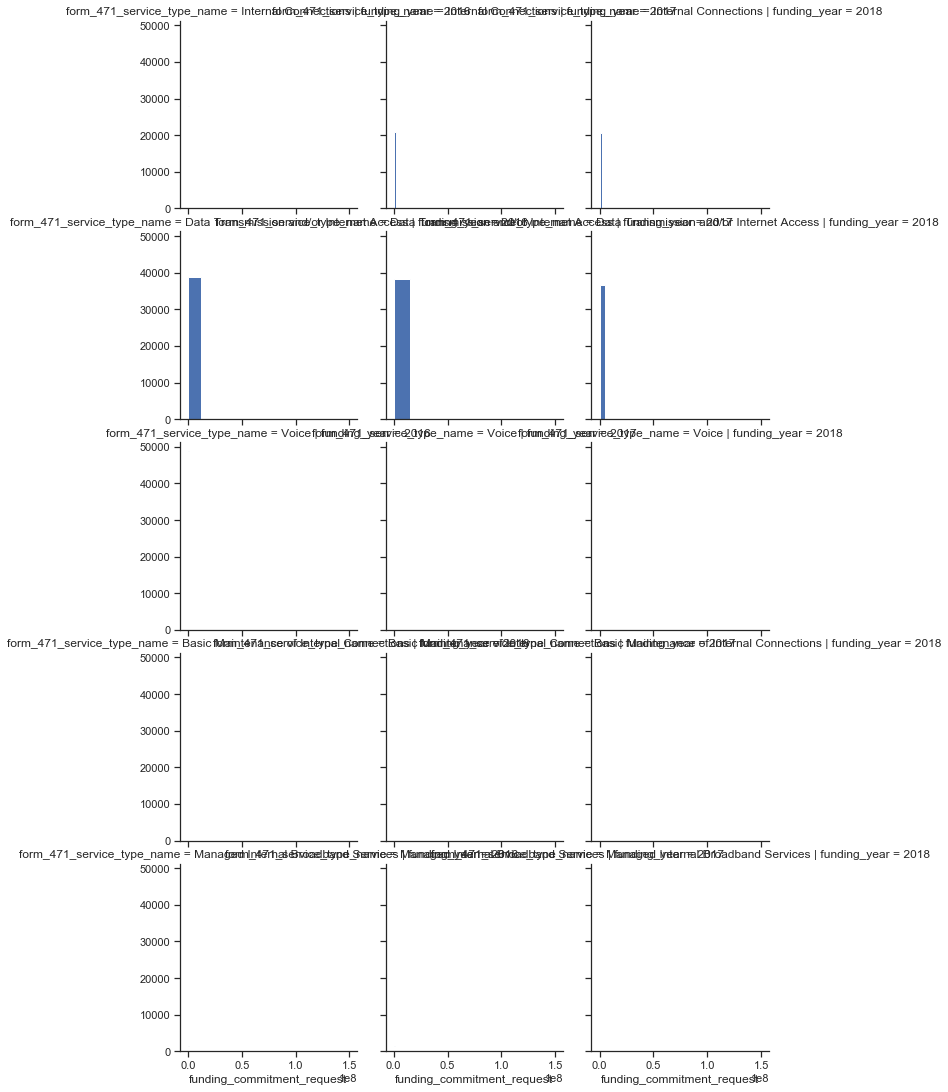

In [65]:
g = sns.FacetGrid(df2, col="funding_year", row="form_471_service_type_name")
g = g.map(plt.hist, "funding_commitment_request")
# g = g.map(plt.scatter, "funding_commitment_request", "form_471_service_type_name", edgecolor="w")

In [5]:
"""
4. Dig deeper into the higher level insights.  
What do you think is contributing to the trends 
you identified above?  Focus on three factors 
that might be affecting the trend in dollars 
requested and the number of funding requests 
received by USAC for E-rate funding.
"""

#less requests = less dollars requested?
# stats.dropna().groupby('funding_year').funding_request_number.nunique()

# stats.dropna().groupby('funding_year').funding_commitment_request.sum()

print('\n Average requested amount grows:')
print(df.groupby('funding_year').funding_commitment_request.sum()/ \
    df.groupby('funding_year').funding_request_number.nunique())


 Average requested amount grows:
funding_year
2016   29,712.04
2017   33,132.03
2018   39,220.74
dtype: float64


In [14]:
print('\n Trend by service type?')
by_service_type = df.groupby(['funding_year','form_471_service_type_name'])\
    .agg({'funding_commitment_request':'sum'}).unstack(0)
print(calc_diff(by_service_type, float_num=2))


 Trend by service type?
                                                      2016             2017  \
form_471_service_type_name                                                    
Basic Maintenance of Internal Connections    47,415,178.58    37,326,057.26   
Data Transmission and/or Internet Access  2,107,894,305.95 2,183,309,242.27   
Internal Connections                      1,088,322,793.67   840,426,449.34   
Managed Internal Broadband Services          29,336,829.15    32,670,137.44   
Voice                                       324,743,254.73   137,469,538.70   

                                                      2018  2016-2017, USD  \
form_471_service_type_name                                                   
Basic Maintenance of Internal Connections    34,869,906.05  -10,089,121.32   
Data Transmission and/or Internet Access  2,070,319,268.43   75,414,936.32   
Internal Connections                        699,552,024.35 -247,896,344.33   
Managed Internal Broadband Serv

In [28]:
by_service_contract = df\
    .groupby(['funding_year','form_471_service_type_name','contract_type_name'])\
    .agg({'funding_commitment_request':'sum'})

In [29]:
by_service_contract

funding_commitment_request
funding_year form_471_service_type_name                contract_type_name                            
2016         Basic Maintenance of Internal Connections Contract                         44,215,535.11
                                                       Month-to-Month                    2,877,914.30
                                                       Tariff                              321,729.17
             Data Transmission and/or Internet Access  Contract                      1,902,540,042.66
                                                       Month-to-Month                  192,690,650.55
                                                       Tariff                           12,663,612.74
             Internal Connections                      Contract                      1,057,901,996.07
                                                       Month-to-Month                   23,332,801.81
                                                       Tariff                            7,087,995.79
             Managed Internal Broadband Services       Contract                         27,601,695.14
                                                       Month-to-Month                    1,578,432.73
                                                       Tariff                              156,701.28
             Voice                                     Contract                        172,461,427.66
                                                       Month-to-Month                  123,467,324.14
                                                       Tariff                           28,814,502.93
2017         Basic Maintenance of Internal Connections Contract                         33,890,523.50
                                                       Month-to-Month                    3,166,685.78
                                                       Tariff                              268,847.98
             Data Transmission and/or Internet Access  Contract                      1,998,728,788.29
                                                       Month-to-Month                  163,530,148.09
                                                       Tariff                           21,050,305.89
             Internal Connections                      Contract                        819,139,560.92
                                                       Month-to-Month                   17,846,568.41
                                                       Tariff                            3,440,320.01
             Managed Internal Broadband Services       Contract                         31,476,904.79
                                                       Month-to-Month                    1,120,805.97
                                                       Tariff                               72,426.68
             Voice                                     Contract                         78,700,869.75
                                                       Month-to-Month                   49,332,762.00
                                                       Tariff                            9,435,211.65
2018         Basic Maintenance of Internal Connections Contract                         31,674,779.77
                                                       Month-to-Month                    3,096,458.57
                                                       Tariff                               98,667.71
             Data Transmission and/or Internet Access  Contract                      1,914,048,225.89
                                                       Month-to-Month                  140,717,589.65
                                                       Tariff                           15,553,452.89
             Internal Connections                      Contract                        677,087,547.41
                                                       Month-to-Month                   19,527,42

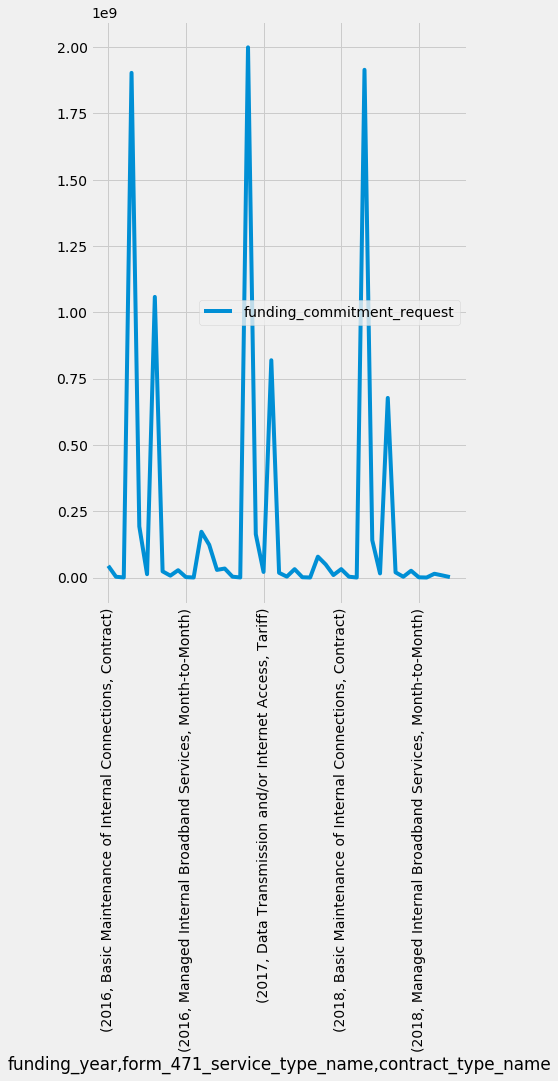

In [30]:
by_service_contract.plot(kind='line', figsize=(6,10), rot=90)

In [403]:
# calc_diff(by_service_type, float_num=2)

2016   2017   2018  \
form_471_service_type_name                                       
Basic Maintenance of Internal Connections   3620   3193   2963   
Data Transmission and/or Internet Access   38818  38232  36658   
Internal Connections                       27949  21009  20633   
Managed Internal Broadband Services         1519   1571   1538   
Voice                                      48829  33269  10926   

                                           2016-2017, USD  2016-2017, %  \
form_471_service_type_name                                                
Basic Maintenance of Internal Connections            -427        -11.80   
Data Transmission and/or Internet Access             -586         -1.51   
Internal Connections                                -6940        -24.83   
Managed Internal Broadband Services                    52          3.42   
Voice                                              -15560        -31.87   

                                           2017-2018, USD  2017-2018, %  
form_471_service_type_name                                               
Basic Maintenance of Internal Connections            -230         -7.20  
Data Transmission and/or Internet Access            -1574         -4.12  
Internal Connections                                 -376         -1.79  
Managed Internal Broadband Services                   -33         -2.10  
Voice                                              -22343        -67.16

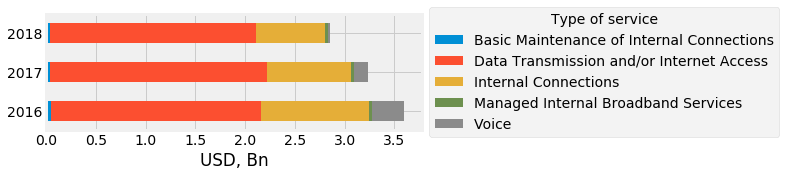

In [6]:
f, ax = plt.subplots()
f.set_facecolor('white')

by_service_type.stack().unstack(0) \
    .plot(ax=ax, kind='barh', stacked=True, figsize=(6,2), rot=0)

ax.set_ylabel('')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000000)))
ax.set_xlabel('USD, Bn')
ax.legend(by_service_type.stack().unstack(0).columns.get_level_values(1),
    title='Type of service',loc='center left',bbox_to_anchor=(1.0, 0.5))

plt.show()

In [136]:
print('Any difference by type of contract?')
print(df.groupby(['funding_year','contract_type_name']).size())

Any difference by type of contract?
funding_year  contract_type_name
2016          Contract              71471
              Month-to-Month        43556
              Tariff                 6059
2017          Contract              60558
              Month-to-Month        32776
              Tariff                 4189
2018          Contract              53990
              Month-to-Month        17088
              Tariff                 1721
dtype: int64


In [406]:
print('Any difference by type of contract?')
by_contract = df.groupby(['funding_year','contract_type_name']) \
      .agg({'funding_commitment_request':sum}) \
      .unstack(0)
calc_diff(by_contract, float_num=2)

Any difference by type of contract?


2016             2017             2018  \
contract_type_name                                                      
Contract           3,204,720,696.64 2,961,936,647.25 2,662,681,166.61   
Month-to-Month       343,947,123.53   234,996,970.25   172,263,251.39   
Tariff                49,044,541.91    34,267,112.21    20,286,181.42   

                    2016-2017, USD  2016-2017, %  2017-2018, USD  2017-2018, %  
contract_type_name                                                              
Contract           -242,784,049.39         -7.58 -299,255,480.64        -10.10  
Month-to-Month     -108,950,153.28        -31.68  -62,733,718.86        -26.70  
Tariff              -14,777,429.70        -30.13  -13,980,930.79        -40.80

In [5]:
by_service_and_contract = df.groupby(['funding_year', 'contract_type_name', 'form_471_service_type_name']) \
    .agg({'funding_commitment_request':sum}) \
    .unstack((0))
    
by_service_and_contract

funding_commitment_request  \
funding_year                                                                       2016   
contract_type_name form_471_service_type_name                                             
Contract           Basic Maintenance of Internal Connections              44,215,535.11   
                   Data Transmission and/or Internet Access            1,902,540,042.66   
                   Internal Connections                                1,057,901,996.07   
                   Managed Internal Broadband Services                    27,601,695.14   
                   Voice                                                 172,461,427.66   
Month-to-Month     Basic Maintenance of Internal Connections               2,877,914.30   
                   Data Transmission and/or Internet Access              192,690,650.55   
                   Internal Connections                                   23,332,801.81   
                   Managed Internal Broadband Services                     1,578,432.73   
                   Voice                                                 123,467,324.14   
Tariff             Basic Maintenance of Internal Connections                 321,729.17   
                   Data Transmission and/or Internet Access               12,663,612.74   
                   Internal Connections                                    7,087,995.79   
                   Managed Internal Broadband Services                       156,701.28   
                   Voice                                                  28,814,502.93   

                                                                               \
funding_year                                                             2017   
contract_type_name form_471_service_type_name                                   
Contract           Basic Maintenance of Internal Connections    33,890,523.50   
                   Data Transmission and/or Internet Access  1,998,728,788.29   
                   Internal Connections                        819,139,560.92   
                   Managed Internal Broadband Services          31,476,904.79   
                   Voice                                        78,700,869.75   
Month-to-Month     Basic Maintenance of Internal Connections     3,166,685.78   
                   Data Transmission and/or Internet Access    163,530,148.09   
                   Internal Connections                         17,846,568.41   
                   Managed Internal Broadband Services           1,120,805.97   
                   Voice                                        49,332,762.00   
Tariff             Basic Maintenance of Internal Connections       268,847.98   
                   Data Transmission and/or Internet Access     21,050,305.89   
                   Internal Connections                          3,440,320.01   
                   Managed Internal Broadband Services              72,426.68   
                   Voice                                         9,435,211.65   

                                                                               
funding_year                                                             2018  
contract_type_name form_471_service_type_name                                  
Contract           Basic Maintenance of Internal Connections    31,674,779.77  
                   Data Transmission and/or Internet Access  1,914,048,225.89  
                   Internal Connections                        677,087,547.41  
                   Managed Internal Broadband Services          25,601,575.98  
                   Voice                                        14,269,037.56  
Month-to-Month     Basic Maintenance of Internal Connections     3,096,458.57  
                   Data Transmission and/or Internet Access    140,717,589.65  
                   Internal Connections                         19,527,423.64  
                   Managed Internal Broadband Services             833,299.92  
   

In [412]:
calc_diff(by_service_and_contract, float_num=2)

2016  \
contract_type_name form_471_service_type_name                                   
Contract           Basic Maintenance of Internal Connections    44,215,535.11   
                   Data Transmission and/or Internet Access  1,902,540,042.66   
                   Internal Connections                      1,057,901,996.07   
                   Managed Internal Broadband Services          27,601,695.14   
                   Voice                                       172,461,427.66   
Month-to-Month     Basic Maintenance of Internal Connections     2,877,914.30   
                   Data Transmission and/or Internet Access    192,690,650.55   
                   Internal Connections                         23,332,801.81   
                   Managed Internal Broadband Services           1,578,432.73   
                   Voice                                       123,467,324.14   
Tariff             Basic Maintenance of Internal Connections       321,729.17   
                   Data Transmission and/or Internet Access     12,663,612.74   
                   Internal Connections                          7,087,995.79   
                   Managed Internal Broadband Services             156,701.28   
                   Voice                                        28,814,502.93   

                                                                         2017  \
contract_type_name form_471_service_type_name                                   
Contract           Basic Maintenance of Internal Connections    33,890,523.50   
                   Data Transmission and/or Internet Access  1,998,728,788.29   
                   Internal Connections                        819,139,560.92   
                   Managed Internal Broadband Services          31,476,904.79   
                   Voice                                        78,700,869.75   
Month-to-Month     Basic Maintenance of Internal Connections     3,166,685.78   
                   Data Transmission and/or Internet Access    163,530,148.09   
                   Internal Connections                         17,846,568.41   
                   Managed Internal Broadband Services           1,120,805.97   
                   Voice                                        49,332,762.00   
Tariff             Basic Maintenance of Internal Connections       268,847.98   
                   Data Transmission and/or Internet Access     21,050,305.89   
                   Internal Connections                          3,440,320.01   
                   Managed Internal Broadband Services              72,426.68   
                   Voice                                         9,435,211.65   

                                                                         2018  \
contract_type_name form_471_service_type_name                                   
Contract           Basic Maintenance of Internal Connections    31,674,779.77   
                   Data Transmission and/or Internet Access  1,914,048,225.89   
                   Internal Connections                        677,087,547.41   
                   Managed Internal Broadband Services          25,601,575.98   
                   Voice                                        14,269,037.56   
Month-to-Month     Basic Maintenance of Internal Connections     3,096,458.57   
                   Data Transmission and/or Internet Access    140,717,589.65   
                   Internal Connections                         19,527,423.64   
                   Managed Internal Broadband Services             833,299.92   
                   Voice                                         8,088,479.61   
Tariff             Basic Maintenance of Internal Connections        98,667.71   
                   Data Transmission and/or Internet Access     15,553,452.89   
                   Internal Connections                          2,937,053.30   
                   Managed Internal Broadband Services              15,205.87   
                   Vo

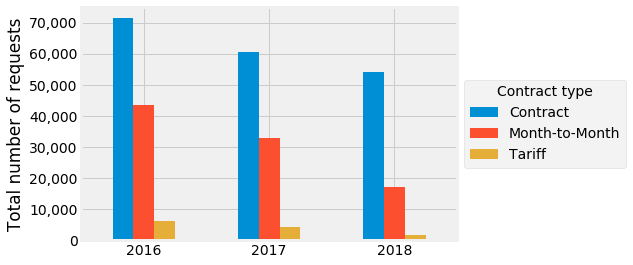

In [137]:
f, ax = plt.subplots()

df.groupby(['funding_year','contract_type_name'])\
    .size()\
    .unstack(level=1)\
    .plot(
        ax=ax,
        kind='bar',
        figsize=(6,4),
        grid=True,
        rot=0,
        )
    
ax.legend(title='Contract type', loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Total number of requests')
f.set_facecolor('white')

plt.show()

Any correlation with number of bids?


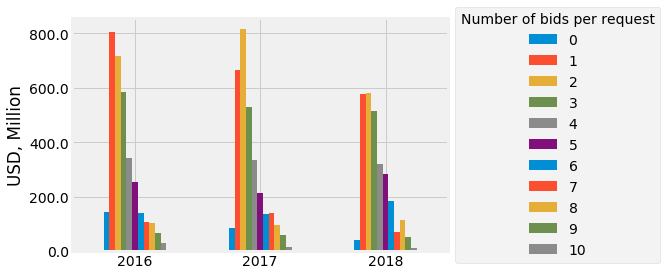

In [138]:
print('Any correlation with number of bids?')

f, ax = plt.subplots()
f.set_facecolor('white')

df[df.bid_count < 11].groupby(['funding_year','bid_count'])\
    .agg({'funding_commitment_request':sum}).unstack(level=1)\
    .plot(ax=ax, 
          figsize=(6,4), 
          kind='bar', 
#           stacked=True, 
          rot=0)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000)))
ax.set_ylabel('USD, Million')
ax.legend([0,1,2,3,4,5,6,7,8,9,10],title='Number of bids per request',loc='center left',bbox_to_anchor=(1.0, 0.5))

plt.show()

In [32]:
by_service_contract = df\
    .groupby(['funding_year','form_471_service_type_name','bid_count'])\
    .agg({'funding_commitment_request':'sum'})
by_service_contract

funding_commitment_request
funding_year form_471_service_type_name                bid_count                                   
2016         Basic Maintenance of Internal Connections 0.00                            1,806,767.97
                                                       1.00                           18,761,286.18
                                                       2.00                            9,068,119.45
                                                       3.00                           10,197,992.31
                                                       4.00                            2,679,664.75
...                                                                                             ...
2018         Voice                                     24.00                              32,880.53
                                                       25.00                              21,584.21
                                                       27.00                              20,702.02
                                                       170,051,121.00                        297.00
                                                       2,076,963,100.00                       84.70

[466 rows x 1 columns]

Any correlation with number of bids?


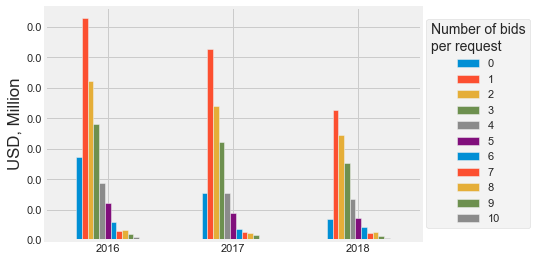

In [422]:
print('Any correlation with number of bids?')

f, ax = plt.subplots()
f.set_facecolor('white')

df[df.bid_count < 11].groupby(['funding_year','bid_count'])\
    .agg({'funding_commitment_request':'count'}).unstack(level=1)\
    .plot(ax=ax, 
          figsize=(6,4), 
          kind='bar', 
#           stacked=True, 
          rot=0)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000)))
ax.set_ylabel('USD, Million')
ax.legend([0,1,2,3,4,5,6,7,8,9,10],title='Number of bids\nper request',loc='center left',bbox_to_anchor=(1.0, 0.5))

plt.show()

In [10]:
by_state_req = df\
    .groupby(['funding_year','state'])\
    .agg(
        {'funding_commitment_request':'count'})\
    .unstack(level=0)

In [461]:
by_state_bid = df[df.bid_count < 11].groupby(['state','funding_year', 'bid_count'])\
    .agg({'funding_commitment_request':sum})\
    .unstack((2))

by_state_bid

funding_commitment_request                              \
bid_count                               0.00          1.00          2.00    
state funding_year                                                          
AK    2016                       2,359,782.16 44,886,757.06 28,634,234.10   
      2017                      13,795,070.11 74,758,573.17 37,887,388.04   
      2018                       2,224,112.89 68,377,842.61 21,276,045.84   
AL    2016                         389,867.79 22,076,910.15  9,747,244.05   
      2017                         269,629.21 18,808,599.76  7,402,039.40   
...                                       ...           ...           ...   
WV    2017                         609,964.40  8,832,860.96  4,983,182.75   
      2018                         499,409.55  7,448,289.06  5,330,552.66   
WY    2016                         815,207.14  1,305,985.91    707,346.76   
      2017                          77,225.28  1,737,177.10    544,465.39   
      2018                          18,737.52  1,468,543.55    812,035.04   

                                                                         \
bid_count                  3.00         4.00         5.00         6.00    
state funding_year                                                        
AK    2016         11,299,728.79   208,769.69 2,879,907.99    51,336.27   
      2017         10,328,396.95   847,274.42    29,354.55    36,427.29   
      2018         35,345,123.48 1,070,169.09          nan          nan   
AL    2016          4,943,853.11 4,361,417.30 5,406,275.18 2,080,912.36   
      2017          4,606,658.36 4,860,897.69   977,299.77   165,419.82   
...                          ...          ...          ...          ...   
WV    2017          2,940,594.55   681,108.79     8,088.00    84,139.80   
      2018          1,976,594.45   684,944.24     3,600.00 1,619,125.86   
WY    2016            876,007.04   327,724.33   340,445.14   220,426.02   
      2017          1,069,518.54 1,299,638.44   373,860.88   125,289.12   
      2018          1,229,754.24   477,305.96   286,934.01   185,980.40   

                                                                     
bid_count                 7.00         8.00      9.00         10.00  
state funding_year                                                   
AK    2016           207,153.59          nan  3,412.50          nan  
      2017                  nan          nan       nan          nan  
      2018                  nan    13,349.60       nan          nan  
AL    2016         1,726,360.43 1,509,598.40       nan 2,008,062.89  
      2017             2,301.20 1,005,667.79       nan   496,312.07  
...                         ...          ...       ...          ...  
WV    2017                  nan          nan       nan          nan  
      2018                  nan          nan       nan          nan  
WY    2016           120,200.14     6,365.00  8,475.50          nan  
      2017            83,099.28    27,780.00 87,159.60          nan  
      2018            77,640.50     1,248.00 59,996.40          nan  

[168 rows x 11 columns]

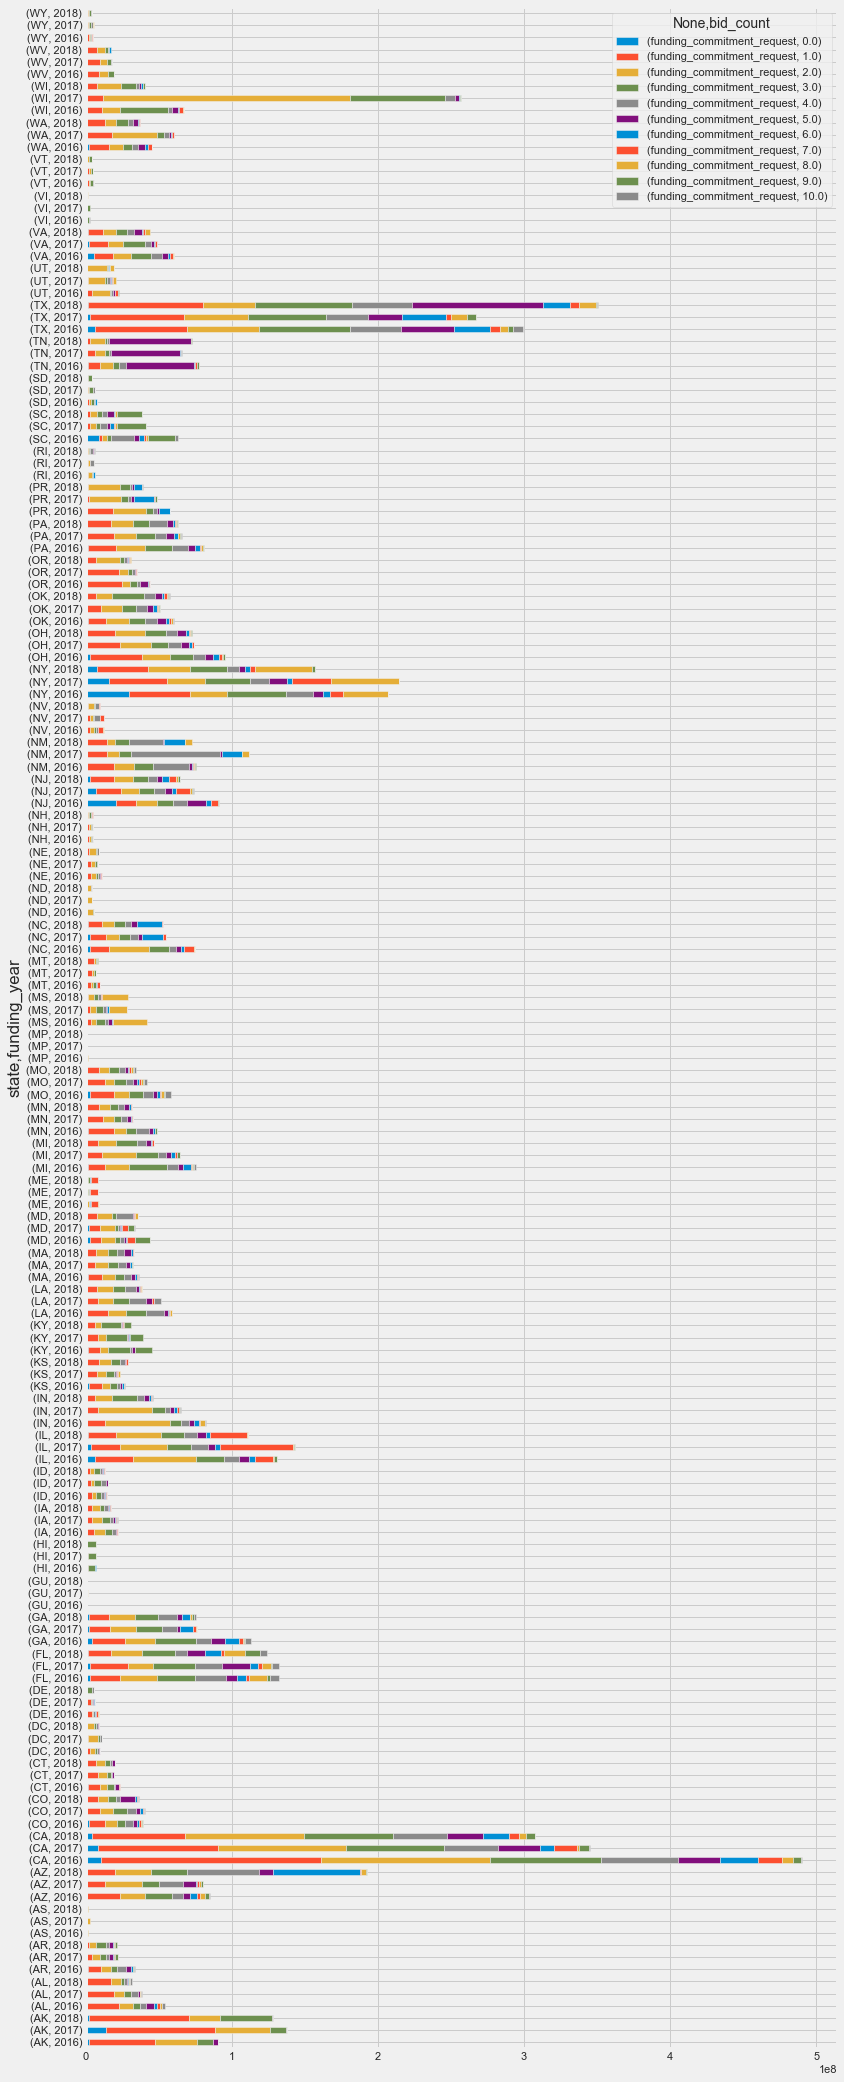

In [466]:
by_state_bid.plot(kind='barh', stacked=True, figsize=(12,35))

In [ ]:
print('Any correlation with number of bids?')

f, ax = plt.subplots()
f.set_facecolor('white')

df[df.bid_count < 11].groupby(['funding_year','bid_count'])\
    .agg({'funding_commitment_request':sum}).unstack(level=1)\
    .plot(ax=ax, 
          figsize=(6,4), 
          kind='bar', 
#           stacked=True, 
          rot=0)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000)))
ax.set_ylabel('USD, Million')
ax.legend([0,1,2,3,4,5,6,7,8,9,10],title='Number of bids per request',loc='center left',bbox_to_anchor=(1.0, 0.5))

plt.show()

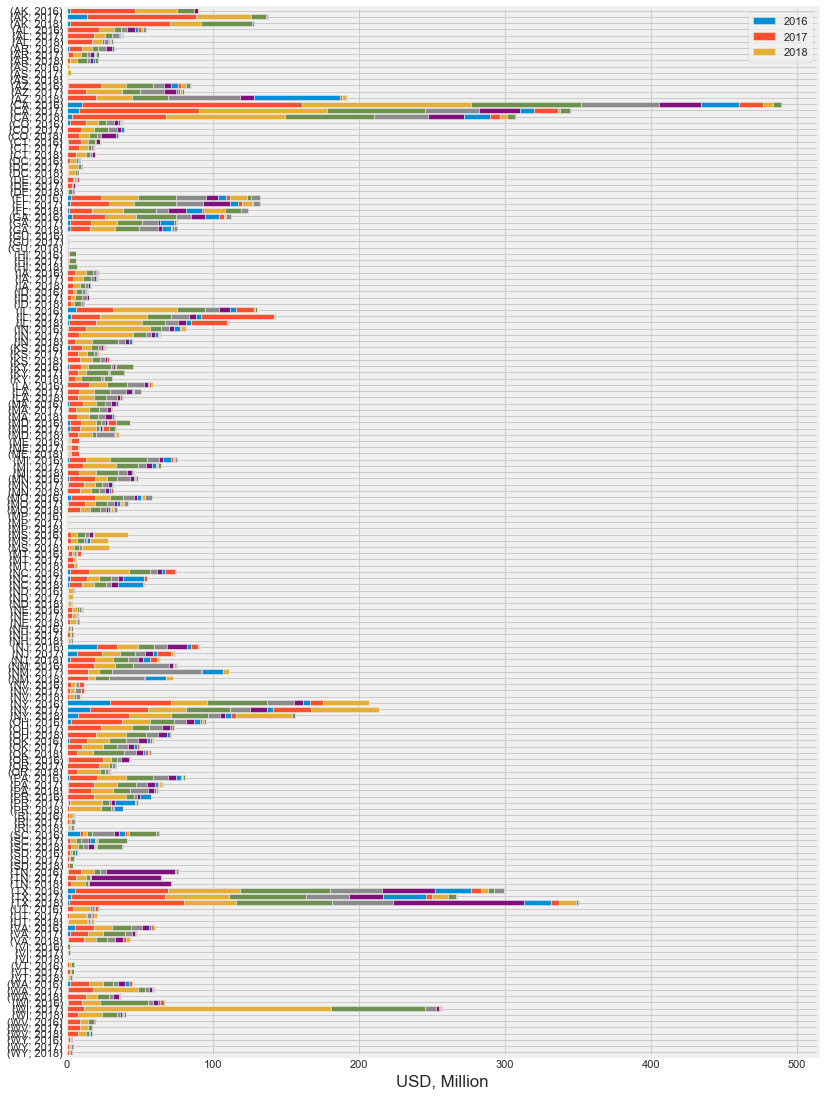

In [472]:
f, ax = plt.subplots()
f.set_facecolor('white')

by_state_bid \
    .plot(ax=ax, kind='barh', stacked=True, figsize=(12,18), width=0.8)

ax.set_xlabel('USD, Million')
ax.set_ylabel('')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)))
ax.legend(labels=['2016','2017','2018'])
ax.invert_yaxis()

plt.show()

In [50]:
df.is_based_on_state_master_contract.value_counts()


No     268477
Yes     22933
Name: is_based_on_state_master_contract, dtype: int64

In [54]:
df.pending_reason.value_counts()

Application Wave Ready                251496
Applicant Documentation Received       19325
15 Day Reminder Notice                  7973
15 Day Expired                          4118
15 Day Notice                           3520
Assigned to IR                           815
Summer Deferral                          787
24 Hour Notice-Incomplete Response       742
First Extension                          442
Two or More Extensions -denied           436
FCDL Issued                              419
Waiting for Heightened Scrutiny          341
QA Review                                292
Incomplete Response                      263
Returned for Additional Review           208
Winter Deferral                          123
Final Review                              45
Escalation to Manager                     38
Escalation to Services                    13
Two or More Extensions Granted             7
Escalation to USAC                         6
Escalation to Procedures                   1
Name: pend

In [53]:
df.award_date.value_counts()

2017-05-10    3231
2017-05-11    3057
2018-03-22    2819
2018-03-21    2714
2017-05-09    2710
              ... 
2011-01-27       1
2014-11-02       1
2011-12-19       1
2011-03-06       1
2015-09-02       1
Name: award_date, Length: 1767, dtype: int64

In [51]:
df.is_multiple_award.value_counts()

No     275654
Yes     15756
Name: is_multiple_award, dtype: int64

How about by type of organization?


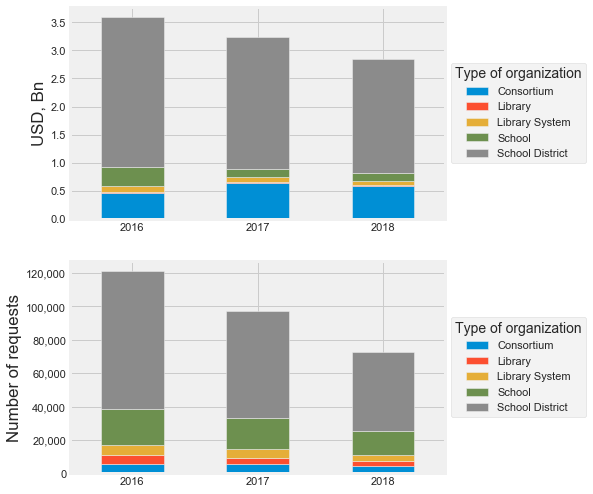

In [494]:
print('How about by type of organization?')

f, (ax2, ax) = plt.subplots(2,1)
f.set_facecolor('white')

df.groupby(['funding_year','organization_entity_type_name'])\
    .size().unstack(level=1).plot(ax=ax, kind='bar', stacked=True, figsize=(6,8), rot=0)

ax.set_xlabel('')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Number of requests')
ax.legend(title='Type of organization',loc='center left',bbox_to_anchor=(1.0, 0.5))

df.groupby(['funding_year','organization_entity_type_name'])\
    .agg({'funding_commitment_request':sum})\
    .unstack(level=1).plot(ax=ax2, kind='bar', stacked=True, rot=0)

ax2.set_xlabel('')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000000)))
ax2.set_ylabel('USD, Bn')
ax2.legend(labels=\
          ['Consortium', 'Library', 'Library System', 'School', 'School District'],\
          title='Type of organization',loc='center left',bbox_to_anchor=(1.0, 0.5))

plt.show()

Any change by service provider?


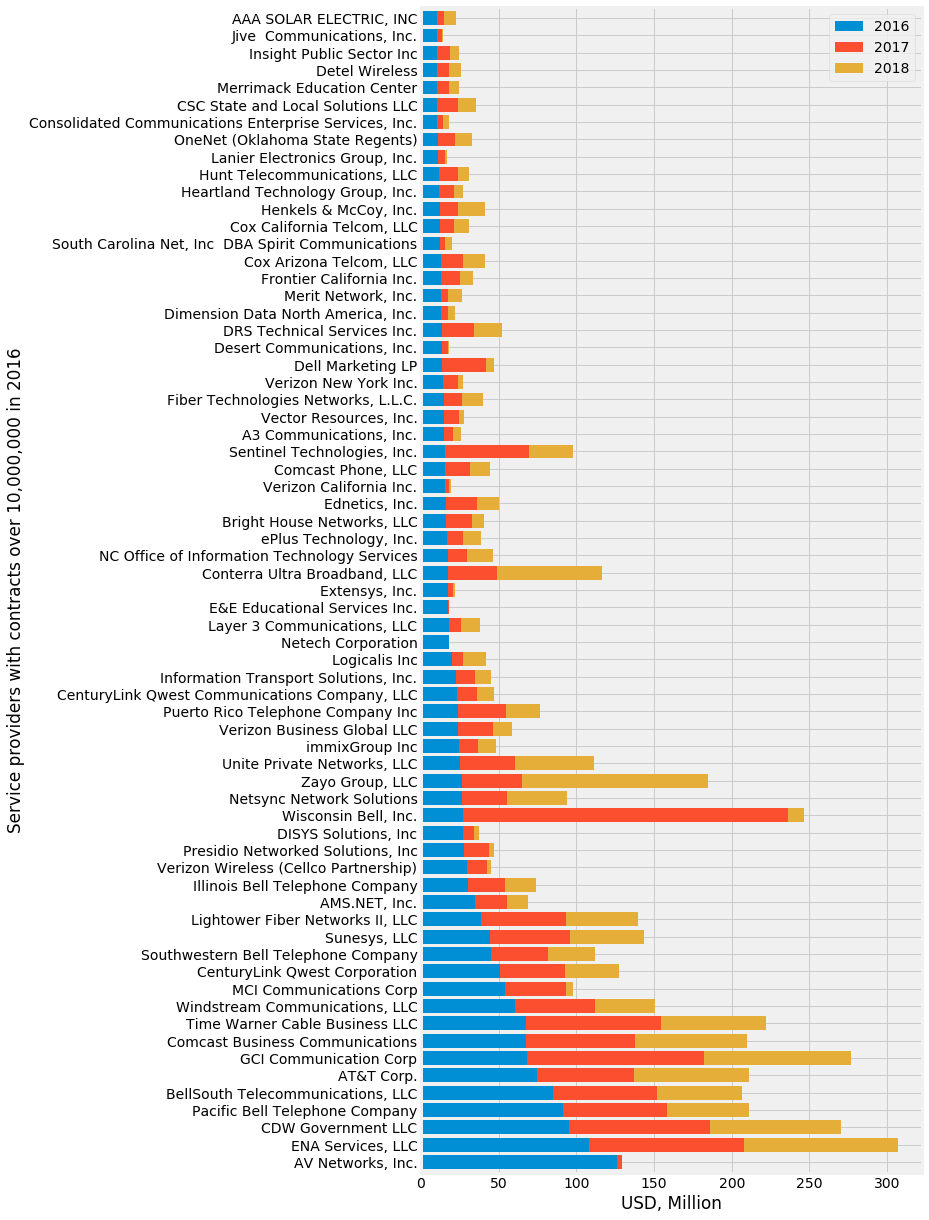

In [61]:
print('Any change by service provider?')

f, ax = plt.subplots()
f.set_facecolor('white')
cutoff = 10000000

by_provider = df.groupby(['funding_year','spin_name']).agg(
        {'funding_commitment_request':sum}).unstack(level=0)

by_provider.loc[by_provider[('funding_commitment_request', 2016)] >= cutoff] \
    .sort_values(by=('funding_commitment_request', 2016)) \
    .plot(ax=ax, kind='barh', stacked=True, figsize=(8,20), width=0.8)

ax.set_xlabel('USD, Million')
ax.set_ylabel('Service providers with contracts over {:,.0f} in 2016'.format(cutoff))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)))
ax.legend(labels=['2016','2017','2018'])
ax.invert_yaxis()

plt.show()

In [87]:
print('Is there a trend by State?')
by_state = df\
    .groupby(['funding_year','state'])\
    .agg(
        {'funding_commitment_request':sum})\
    .unstack(level=0)
by_state.columns = ['2016','2017','2018']

by_state_req = df\
    .groupby(['funding_year','state'])\
    .agg(
        {'funding_commitment_request':'count'})\
    .unstack(level=0)

by_state.columns = ['2016','2017','2018']
by_state_req.columns = ['2016','2017','2018']

by_state_pop = by_state.copy()
by_state_req_pop = by_state_req.copy()

Is there a trend by State?


In [70]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [71]:
import numpy as np
print('Adjusted by population')
population = pd.read_csv('state-pop.csv',index_col='state', dtype={'pop':np.int32})
total_population = population.loc['United States',:]['pop']

Adjusted by population


In [72]:
print(f'US Population: {total_population}')

US Population: 328239523


In [73]:
population.dtypes

pop    int32
dtype: object

In [88]:
# converting full state names to abbreviations
for i, row in population.iterrows():
    for state in states.values():
        if i == state: 
            population.rename(\
                              index={i: list(states.keys())[list(states.values()).index(state)]},\
                              inplace=True)

In [89]:
# adjusting absolute number to population numbers
for i, row in by_state_pop.iterrows():
#     print(i, row)
    for k, col in row.iteritems():
        pop_coef = population.loc[i,'pop'] / 100000
#         print(f'Population coefficient for {i}: {pop_coef}')
        by_state_pop.loc[str(i),k] = (col / pop_coef)
by_state_pop.head()

Population coefficient for AK: 7.31545
Population coefficient for AK: 7.31545
Population coefficient for AK: 7.31545
Population coefficient for AL: 49.03185
Population coefficient for AL: 49.03185
Population coefficient for AL: 49.03185
Population coefficient for AR: 30.17804
Population coefficient for AR: 30.17804
Population coefficient for AR: 30.17804
Population coefficient for AS: 0.55191
Population coefficient for AS: 0.55191
Population coefficient for AS: 0.55191
Population coefficient for AZ: 72.78717
Population coefficient for AZ: 72.78717
Population coefficient for AZ: 72.78717
Population coefficient for CA: 395.12223
Population coefficient for CA: 395.12223
Population coefficient for CA: 395.12223
Population coefficient for CO: 57.58736
Population coefficient for CO: 57.58736
Population coefficient for CO: 57.58736
Population coefficient for CT: 35.65287
Population coefficient for CT: 35.65287
Population coefficient for CT: 35.65287
Population coefficient for DC: 7.05749
Popu

2016          2017          2018
state                                          
AK    12,375,326.49 18,820,781.30 17,539,132.04
AL     1,144,026.79    847,838.43    704,620.44
AR     1,568,769.54  1,206,804.39  1,142,104.65
AS     2,748,407.66  5,325,016.52  2,395,814.14
AZ     1,245,387.08  1,136,937.95  2,674,330.41

In [90]:
for i, row in by_state_req_pop.iterrows():
#     print(i, row)
    for k, col in row.iteritems():
        pop_coef = population.loc[i,'pop'] / 100000
#         print(f'Population coefficient for {i}: {pop_coef}')
        by_state_req_pop.loc[str(i),k] = (col / pop_coef)
by_state_req_pop.head()

2016  2017  2018
state                  
AK    54.68 49.62 40.74
AL    25.84 19.99 13.71
AR    44.01 34.53 20.84
AS     9.06 56.17  7.25
AZ    34.46 32.09 26.02

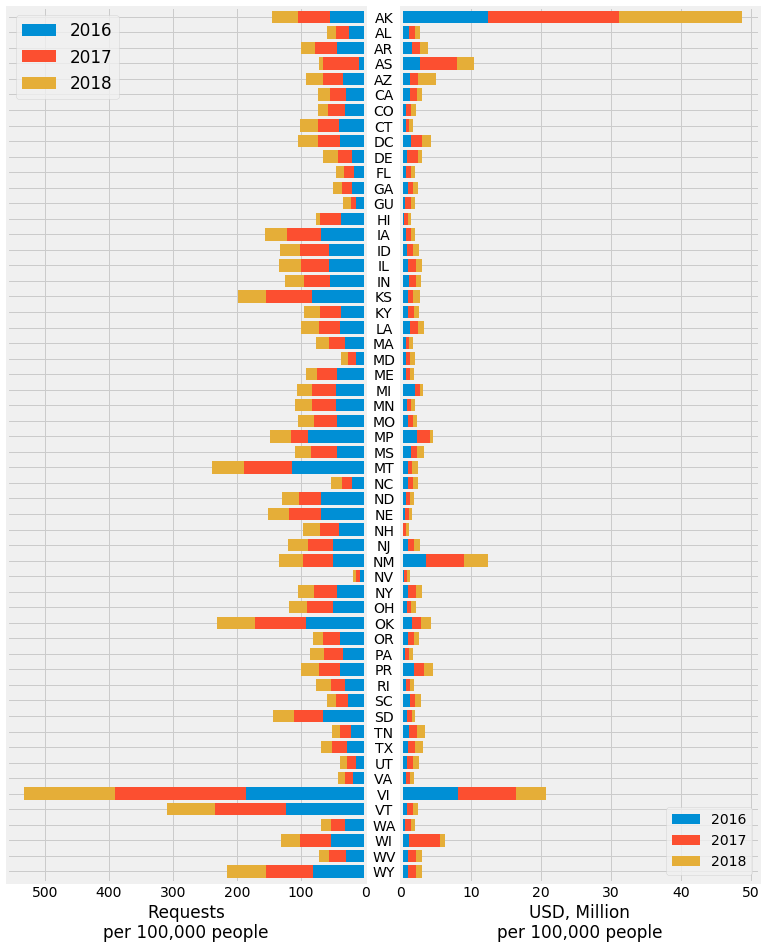

In [133]:
f, (ax2, ax) = plt.subplots(1, 2, gridspec_kw={'wspace': 0.1})
f.set_facecolor('white')

by_state_pop.sort_index() \
    .plot(ax=ax, kind='barh', stacked=True, figsize=(12,15), width=0.8)

by_state_req_pop.sort_index()\
    .plot(ax=ax2, kind='barh', figsize=(12,15), stacked=True,\
    width=0.8, legend=None)

ax.set_ylabel('')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)))
ax.set_xlabel('USD, Million\nper 100,000 people')
for label in ax.get_yticklabels():
    label.set_horizontalalignment('center')
ax.tick_params('y', pad=17)

ax2.set_ylabel('')
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.legend(labels=['2016','2017','2018'], fontsize='large')
ax2.set_yticklabels('')
# ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_xlabel('Requests\nper 100,000 people')



plt.show()

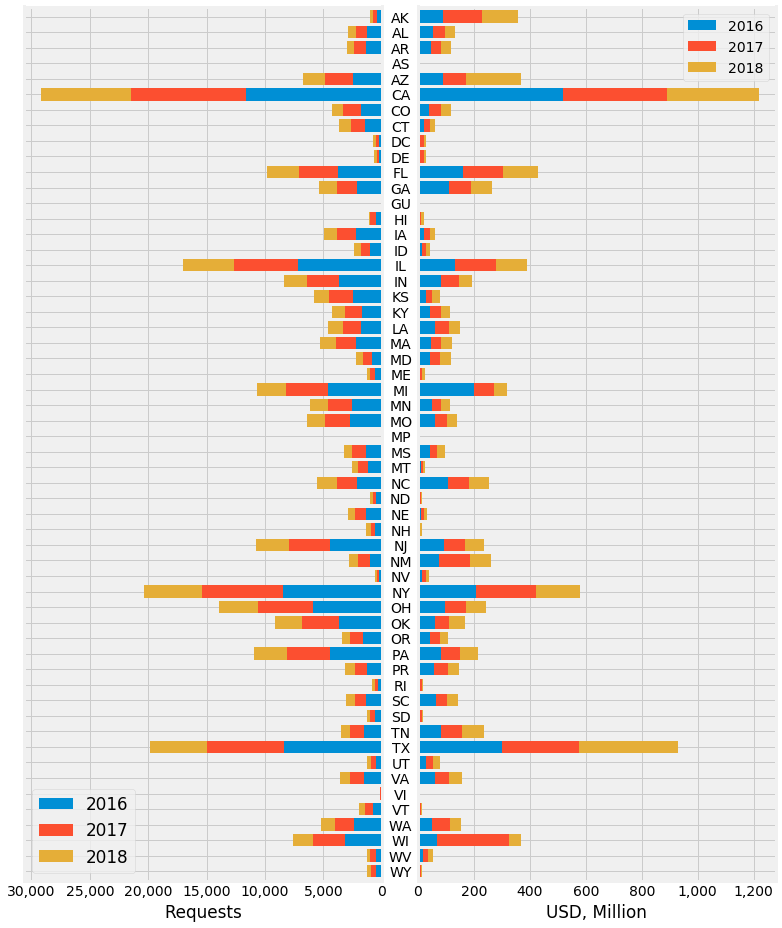

In [135]:
f, (ax2, ax) = plt.subplots(1, 2, gridspec_kw={'wspace': 0.1})
f.set_facecolor('white')

by_state.sort_index() \
    .plot(ax=ax, kind='barh', stacked=True, figsize=(12,15), width=0.8)

by_state_req.sort_index() \
    .plot(ax=ax2, kind='barh', stacked=True, width=0.8,\
    legend=None)

# ax.set_title('Dollar value')
ax.set_ylabel('')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)))
ax.set_xlabel('USD, Million')
for label in ax.get_yticklabels():
    label.set_horizontalalignment('center')
ax.tick_params('y', pad=17)


ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_ylabel('')
ax2.set_yticklabels('')
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_xlabel('Requests')
ax2.legend(labels=['2016','2017','2018'], fontsize='large')



plt.show()

In [140]:
# from urllib.request import urlopen
# import json
# with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#     counties = json.load(response)

import os

if not os.path.exists("images"):
    os.mkdir("images")

# unstacking column from multiindex to ease csv operations
# by_state.columns = by_state.columns.get_level_values(1)
by_state.to_csv('by_state.csv')

# used addfips package
!addfips by_state.csv --state-field state > by_state_with_fips.csv

by_state_fips = pd.read_csv('by_state_with_fips.csv', dtype={"fips": str})

# import plotly.express as px

import plotly.graph_objects as go

In [141]:
year = '2016'

fig = go.Figure(data=go.Choropleth(
    locations=by_state_fips['state'], # Spatial coordinates
    z = by_state_fips[year].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
    zmin=0,
    zmax=500000000
))

fig.update_layout(
    title_text = f'Total USAC funding by state, {year}',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image(f'images/{year}.png', scale=2)

In [142]:
year = '2017'

fig = go.Figure(data=go.Choropleth(
    locations=by_state_fips['state'], # Spatial coordinates
    z = by_state_fips[year].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
    zmin=0,
    zmax=500000000
))

fig.update_layout(
    title_text = f'Total USAC funding by state, {year}',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image(f'images/{year}.png', scale=2)

In [143]:
year = '2018'

fig = go.Figure(data=go.Choropleth(
    locations=by_state_fips['state'], # Spatial coordinates
    z = by_state_fips[year].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
    zmin=0,
    zmax=500000000
))

fig.update_layout(
    title_text = f'Total USAC funding by state, {year}',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image(f'images/{year}.png', scale=2)

In [ ]:
#Did the length of the contract increased?

# 5.	Create a data product that visualizes your insights and highlights your results at an executive summary level.

In [85]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291410 entries, 0 to 291409
Data columns (total 62 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   account_number                               146604 non-null  object        
 1   annual_interest_rate                         138 non-null     float64       
 2   application_number                           291410 non-null  int64         
 3   avg_cost_per_ft_of_plant                     1198 non-null    float64       
 4   award_date                                   186019 non-null  datetime64[ns]
 5   balloon_payment_desc                         3 non-null       object        
 6   ben                                          291410 non-null  int64         
 7   bid_count                                    291408 non-null  float64       
 8   cnct_email                                   291407 non-null  ob

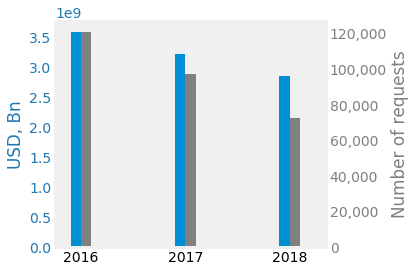

In [102]:
f, ax = plt.subplots()
f.set_facecolor('white')

ax2 = ax.twinx() 
width = 0.1

agg_stats.funding_commitment_request.plot(
        ax=ax,
        kind='bar', 
        figsize=(6,4),
        width=width, 
        position=1,
        rot=0,
        grid=False
    )

agg_stats.funding_request_number.plot(
        kind='bar', 
        color='grey',
        ax=ax2, 
        width=width, 
        position=0,
        grid=False
    )

# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_ylabel('USD, Bn', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.set_xlabel('')
ax2.set_ylabel('Number of requests', color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey')

plt.tight_layout()
plt.show()

6.      Please provide me with the code used to generate the report.

# Notes for hypotesys

by_state
1. разбить штаты на три группы: тренд вниз, тренд вверх, тренд такой же
    потом попытаться понять, что происходило в этих штатах

increase trend
2016<2017
2017<2018

2. Сделать пересчет на единицу населения, на количество школ??

3. Посчитать по статусу заявки: form_471_frn_status_name
    
4. Number of bids by state. Разбить на группы по количеству денег (bins 100K,<1M,<100M)

5. is_based_on_state_master_contract по суммам

6. is_multiple_award

7. award_date compared, service_start_date to application_dat??? whether it became harder to apply for funding
contract_expiration_date

8. if extended_expiration_date < award_date??? просрали полимеры

9. service_delivery_deadline < award_date

10. old_funding_request_number посмотреть тенденцию

11. total_monthly_recurring_cost, total_monthly_recurring_eligible_costs, total_pre_discount_eligible_recurring_costs сравнить total_monthly_recurring_ineligible_costs если USAC покрывает какой-то малый процент, то может быть школам не интересно этим заниматься. Сравнить покрытие также по типам услуги (может быть voice перестали покрывать вообще?) total_one_time_costs, total_ineligible_one_time_costs, total_pre_discount_eligible_one_time_costs, state_tribe_match_amt, source_of_matching_funds_desc
df.pending_reason.value_counts()

12. months_of_service может быть это одноразовые выплаты и школы подают заявки на там два года???

13. dis_pct

14. form_471_frn_fiber_type_name, form_471_frn_fiber_sub_type_name, is_lease, total_proj_plant_route_feet дистанция падает с годами? avg_cost_per_ft_of_plant, eligible_strands_qty total_financed_amt

15. total_authorized_disbursement